#多位点分析
#工作目录：D:\Postdoc\Projects\ESCC_TCR\TRUST\Trust4_vs_clinical_info

#https://omnideconv.org/immunedeconv/articles/detailed_example.html

In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)
#library(immunedeconv)
library(tibble)
library(data.table)
library(reshape2)
library(pheatmap)
#library(msigdbr)
library(cowplot)
library(patchwork)

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200) 


载入程辑包：'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



载入程辑包：'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last



载入程辑包：'reshape2'


The following objects are masked from 'package:data.table':

    dcast, melt


The following object is masked from 'package:tidyr':

    smiths



载入程辑包：'patchwork'


The following object is masked from 'package:cowplot':

    align_plots




In [2]:
#IG类型比较
mypal <- ggsci::pal_npg(palette ="nrc", alpha = 0.7)(10)
mypal2<-ggsci::pal_jama(palette ="default", alpha = 0.7)(6)
mypal3<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.7)(9)
mypal4 <- ggsci::pal_npg(palette ="nrc", alpha = 0.5)(10)
mypal5<-ggsci::pal_jama(palette ="default", alpha = 0.5)(6)
mypal6<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.5)(9)
mypal7 <- ggsci::pal_npg(palette ="nrc", alpha = 0.3)(10)
mypal8<-ggsci::pal_jama(palette ="default", alpha = 0.3)(6)
mypal9<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.3)(9)

mypal<-c(mypal3,mypal2,mypal,mypal6,mypal5,mypal4,mypal9,mypal8,mypal7)
mypal[3]<-"#FFBD7A"


# 四、各基因、细胞类型、diversity feature生存曲线

In [48]:
#mcp
res_mcp_counter_MR<-fread("MR_deconvolution_mcp_counter.new.csv") %>% as.data.frame()
MR_mcp_counter_out<-t(res_mcp_counter_MR[,-1])%>%as.data.frame()
colnames(MR_mcp_counter_out)<-paste("Mcp_counter.",res_mcp_counter_MR$cell_type,sep="")
MR_mcp_counter_out<-rownames_to_column(MR_mcp_counter_out,"ID")

#cibersort
MR_cibersort_out<-fread("MR_Cirbersot_out.new.txt")
colnames(MR_cibersort_out)[-1]<-paste("Cibersort.",colnames(MR_cibersort_out)[-1],sep="")


#survival
survival_data_orig<-fread("MR_survival_diversity.csv") 

#smoke drink
smoke_drink_info<-fread("MR_smoke_drink_info.csv")

#expr
data_multi<-fread("MR_expr_cibersort_input.new.txt")%>% as.data.frame()
data_multi_expr<-column_to_rownames(data_multi,var="GENE")

data_multi_mat<-t(data_multi_expr)
colnames(data_multi_mat)<-data_multi[,1]
MR_expr<-as.data.frame(data_multi_mat)
MR_expr<-rownames_to_column(MR_expr,var="ID")

dim(survival_data_orig)
dim(MR_expr)


MR_VJ_usage<-fread("MR_VJ_usage.csv")
#MR_VJ_usage<-fread("MR_VJ_usage.allele.csv")

#1.merge suvival and expr
survival_data_orig<-merge(survival_data_orig,smoke_drink_info,by="Patient_ID")
survival_IGH_deversity_gene_expr<-merge(survival_data_orig,MR_expr,by="ID")

#add group col 
survival_IGH_deversity_gene_expr$group = substr(survival_IGH_deversity_gene_expr$type,1,1)

#2.merge VJ usage
survival_IGH_deversity_gene_expr<-merge(survival_IGH_deversity_gene_expr,MR_VJ_usage,by="ID")

#3.merge survival gene expr with 2 deconv
survival_IGH_deversity_gene_expr_deconv<-merge(survival_IGH_deversity_gene_expr,MR_cibersort_out,by="ID")
survival_IGH_deversity_gene_expr_deconv<-merge(survival_IGH_deversity_gene_expr_deconv,MR_mcp_counter_out,by="ID")

survival_IGH_deversity_gene_expr_deconv[1:5,1:5]
survival_IGH_deversity_gene_expr_deconv<-as.data.frame(survival_IGH_deversity_gene_expr_deconv)

survival_IGH_deversity_gene_expr_deconv$Smoking<-factor(survival_IGH_deversity_gene_expr_deconv$Smoking,levels=c("never","light","moderate","heavy"))
survival_IGH_deversity_gene_expr_deconv$Drinking<-factor(survival_IGH_deversity_gene_expr_deconv$Drinking,levels=c("never","light","moderate","heavy"))

rname_col<-gsub(colnames(survival_IGH_deversity_gene_expr_deconv),pattern ="s_richness_",replacement = "sequence.richness.")
rname_col<-gsub(rname_col,pattern ="_proportion_redundant",replacement = ".sequence.proportion")
#rname_col

colnames(survival_IGH_deversity_gene_expr_deconv)<-rname_col

[1] 651  51

[1]   654 60584

ID        Patient_ID Gender Age Location
1 ESCC001N  ESCC001    Male   60  Middle  
2 ESCC001T1 ESCC001    Male   60  Middle  
3 ESCC001T2 ESCC001    Male   60  Middle  
4 ESCC001T3 ESCC001    Male   60  Middle  
5 ESCC001T4 ESCC001    Male   60  Middle

In [49]:
#survival_IGH_deversity_gene_expr_deconv<-read.csv("survival_IGH_deversity_gene_expr_deconv.csv",header=TRUE,check.names=FALSE)

## 筛选TNL数据
T_data<-survival_IGH_deversity_gene_expr_deconv[grep("T",survival_IGH_deversity_gene_expr_deconv$type),]
N_data<-survival_IGH_deversity_gene_expr_deconv[grep("N",survival_IGH_deversity_gene_expr_deconv$type),]
L_data<-survival_IGH_deversity_gene_expr_deconv[grep("L",survival_IGH_deversity_gene_expr_deconv$type),]

In [68]:
colnames(survival_IGH_deversity_gene_expr_deconv)[grep("Mcp",colnames(survival_IGH_deversity_gene_expr_deconv))]
colnames(survival_IGH_deversity_gene_expr_deconv)[grep("Ciber",colnames(survival_IGH_deversity_gene_expr_deconv))]

[1] "Mcp_counter.T cell"                      
 [2] "Mcp_counter.T cell CD8+"                 
 [3] "Mcp_counter.cytotoxicity score"          
 [4] "Mcp_counter.NK cell"                     
 [5] "Mcp_counter.B cell"                      
 [6] "Mcp_counter.Monocyte"                    
 [7] "Mcp_counter.Macrophage/Monocyte"         
 [8] "Mcp_counter.Myeloid dendritic cell"      
 [9] "Mcp_counter.Neutrophil"                  
[10] "Mcp_counter.Endothelial cell"            
[11] "Mcp_counter.Cancer associated fibroblast"

[1] "Cibersort.B cells naive"               
 [2] "Cibersort.B cells memory"              
 [3] "Cibersort.Plasma cells"                
 [4] "Cibersort.T cells CD8"                 
 [5] "Cibersort.T cells CD4 naive"           
 [6] "Cibersort.T cells CD4 memory resting"  
 [7] "Cibersort.T cells CD4 memory activated"
 [8] "Cibersort.T cells follicular helper"   
 [9] "Cibersort.T cells regulatory (Tregs)"  
[10] "Cibersort.T cells gamma delta"         
[11] "Cibersort.NK cells resting"            
[12] "Cibersort.NK cells activated"          
[13] "Cibersort.Monocytes"                   
[14] "Cibersort.Macrophages M0"              
[15] "Cibersort.Macrophages M1"              
[16] "Cibersort.Macrophages M2"              
[17] "Cibersort.Dendritic cells resting"     
[18] "Cibersort.Dendritic cells activated"   
[19] "Cibersort.Mast cells resting"          
[20] "Cibersort.Mast cells activated"        
[21] "Cibersort.Eosinophils"                 
[22] "Cibersort.Neutrophils"                 
[23] "Cibersort.P-value"                     
[24] "Cibersort.Correlation"                 
[25] "Cibersort.RMSE"

## 4.1 T、B细胞生存曲线绘制

In [13]:
colnames(survival_IGH_deversity_gene_expr_deconv)

[1] "ID"                                      
    [2] "Patient_ID"                              
    [3] "Gender"                                  
    [4] "Age"                                     
    [5] "Location"                                
    [6] "TNM"                                     
    [7] "Tumor_grade"                             
    [8] "Lymphatic_metastasis"                    
    [9] "Survival_status"                         
   [10] "Survival_time"                           
   [11] "Cohort"                                  
   [12] "type"                                    
   [13] "s_richness"                              
   [14] "s_shannon"                               
   [15] "s_clonality"                             
   [16] "IGHM_proportion_unique"                  
   [17] "IGHM.sequence.proportion"                
   [18] "sequence.richness.IGHM"                  
   [19] "s_count_IGHM"                            
   [20] "IGHD_proportion_unique"                  
   [21] "IGHD.sequence.proportion"                
   [22] "sequence.richness.IGHD"                  
   [23] "s_count_IGHD"                            
   [24] "IGHA1_proportion_unique"                 
   [25] "IGHA1.sequence.proportion"               
   [26] "sequence.richness.IGHA1"                 
   [27] "s_count_IGHA1"                           
   [28] "IGHA2_proportion_unique"                 
   [29] "IGHA2.sequence.proportion"               
   [30] "sequence.richness.IGHA2"                 
   [31] "s_count_IGHA2"                           
   [32] "IGHG1_proportion_unique"                 
   [33] "IGHG1.sequence.proportion"               
   [34] "sequence.richness.IGHG1"                 
   [35] "s_count_IGHG1"                           
   [36] "IGHG2_proportion_unique"                 
   [37] "IGHG2.sequence.proportion"               
   [38] "sequence.richness.IGHG2"                 
   [39] "s_count_IGHG2"                           
   [40] "IGHG3_proportion_unique"                 
   [41] "IGHG3.sequence.proportion"               
   [42] "sequence.richness.IGHG3"                 
   [43] "s_count_IGHG3"                           
   [44] "IGHG4_proportion_unique"                 
   [45] "IGHG4.sequence.proportion"               
   [46] "sequence.richness.IGHG4"                 
   [47] "s_count_IGHG4"                           
   [48] "IGHE_proportion_unique"                  
   [49] "IGHE.sequence.proportion"                
   [50] "sequence.richness.IGHE"                  
   [51] "s_count_IGHE"                            
   [52] "Smoking"                                 
   [53] "Drinking"                                
   [54] "TSPAN6"                                  
   [55] "TNMD"                                    
   [56] "DPM1"                                    
   [57] "SCYL3"                                   
   [58] "C1orf112"                                
   [59] "FGR"                                     
   [60] "CFH"                                     
   [61] "FUCA2"                                   
   [62] "GCLC"                                    
   [63] "NFYA"                                    
   [64] "STPG1"                                   
   [65] "NIPAL3"                                  
   [66] "LAS1L"                                   
   [67] "ENPP4"                                   
   [68] "SEMA3F"                                  
   [69] "CFTR"                                    
   [70] "ANKIB1"                                  
   [71] "CYP51A1"                                 
   [72] "KRIT1"                                   
   [73] "RAD52"                                   
   [74] "MYH16"                                   
   [75] "BAD"                                     
   [76] "LAP3"                                    
   [77] "CD99"                                    
   [78] "HS3ST1"                                  
   [79] "AOC1"            

#### 使用中位数绘制

In [5]:
survival_data<-T_data

survival_data$TNM_flag[survival_data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"ⅡII"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
survival_data$TNM_flag[survival_data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa")]<-"ⅢIII"#,"\u2162" # Ⅲ
survival_data$TNM_flag[survival_data$TNM %in% c("IVa")]<-"ⅣIV"#"\u2163" # Ⅳ

survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1")]<-"G1"#"Ⅰ&Ⅱ"#\u2160&
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1-2","G2")]<-"G2" # Ⅲ
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G2-3","G2-G3","G2/3","G3","Upper G2, Lower G3")]<-"G3"

survival_data$Location[survival_data$Location=="Upper&Lower"]="Upper"

survival_data$Age_flag[survival_data$Age>=60]<-"older(>=60)"
survival_data$Age_flag[survival_data$Age<60]<-"younger"

diversity_features<-c('s_richness','s_shannon',
    'sequence.richness.IGHM',
    'sequence.richness.IGHD',
    'sequence.richness.IGHA1','sequence.richness.IGHA2',
    'sequence.richness.IGHG1','sequence.richness.IGHG2','sequence.richness.IGHG3','sequence.richness.IGHG4',
    'sequence.richness.IGHE',
    "Mcp_counter.T cell CD8+","Mcp_counter.B cell"
    )


In [19]:
colnames(survival_data)[selected_cols]

[1] "ID"                      "Patient_ID"             
 [3] "Gender"                  "Survival_status"        
 [5] "sequence.richness.IGHM"  "sequence.richness.IGHD" 
 [7] "sequence.richness.IGHG1" "sequence.richness.IGHG2"
 [9] "Smoking"                 "Age_flag"               
[11] NA                        NA                       
[13] NA                        NA                       
[15] NA                        NA                       
[17] NA                        NA                       
[19] NA                        NA                       
[21] NA                        NA

In [6]:

selected_cols<-colnames(survival_data) %in% c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag",diversity_features)
survival_data<-survival_data[,selected_cols]



patients<-unique(survival_data$Patient_ID)
survival_data_m<-tibble()
    for(p in patients){
        p_data<-survival_data[survival_data$Patient_ID==p,]
        p_data_info<-p_data[1,c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag")]
        p_data_info<-as.vector(t(p_data_info))

        p_data_feature<-p_data[,diversity_features]
        p_data_feature_new<-apply(p_data_feature,2,function(x){median(x)})
        p_data_m<-c(p_data_info,p_data_feature_new)
        survival_data_m<-rbind(survival_data_m,p_data_m)
    }

colnames(survival_data_m)<-c(c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag"),diversity_features)
survival_data_m[,c("Survival_time","Survival_status",diversity_features)]<-apply(survival_data_m[,c("Survival_time","Survival_status",diversity_features)],2,function(x){as.numeric(x)})

survival_data<-as.data.frame(survival_data_m)


unique(survival_data$TNM)
dim(survival_data)

survival_data$Age_flag<-factor(survival_data$Age_flag,levels=c("younger","older(>=60)"))
survival_data$Smoking<-factor(survival_data$Smoking,levels=c("never","light","moderate","heavy"))
survival_data$Drinking<-factor(survival_data$Drinking,levels=c("never","light","moderate","heavy"))
#survival_data$TNM_flag<-factor(survival_data$TNM_flag,levels=c("II","III","IV"))


[1] "ⅡII"  "ⅢIII" "ⅣIV"

[1] 107  24

## Fig3A-C

In [ ]:
T_survival_cibersort

载入需要的程辑包：ggpubr


载入程辑包：'ggpubr'


The following object is masked from 'package:cowplot':

    get_legend



载入程辑包：'survminer'


The following object is masked from 'package:survival':

    myeloma




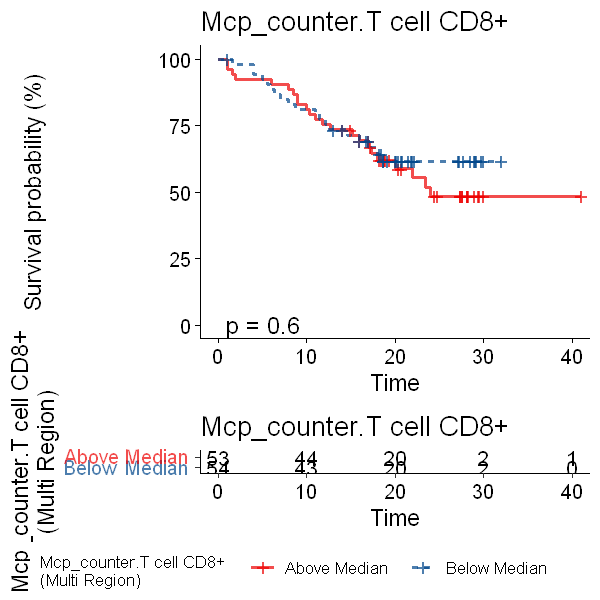

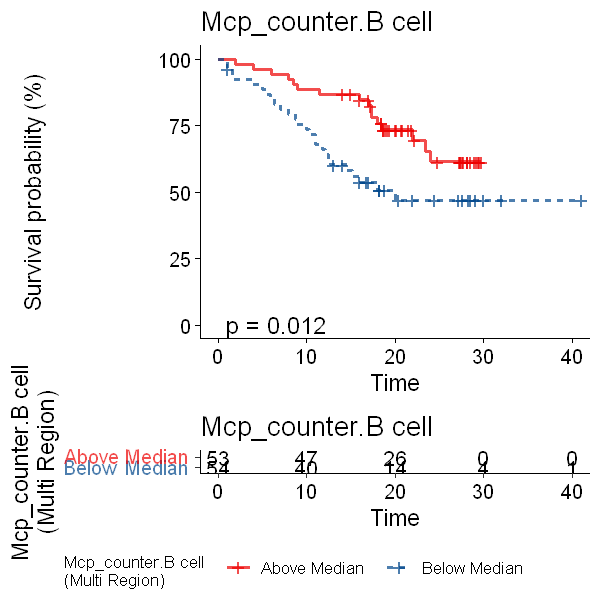

In [7]:

library(survival)
library(survminer)

options(repr.plot.width = 8, repr.plot.height = 8)

celltypes<-c("Mcp_counter.T cell CD8+","Mcp_counter.B cell")
T_survival_cibersort<-survival_data

for (celltype in celltypes){
#gene="IGHG_redundant"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]>median(T_survival_cibersort[,celltype])]<-"high"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]<=median(T_survival_cibersort[,celltype])]<-"low"

fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=T_survival_cibersort)

options(repr.plot.width = 5, repr.plot.height = 5)
xx<-ggsurvplot(fit, data = T_survival_cibersort,
           conf.int = FALSE,
           pval = TRUE,           
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           #palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           palette = c(mypal[2],mypal[1]),
           legend = "bottom",
           legend.labs = c("Above Median","Below Median"),
           legend.title = paste(celltype,"\n(Multi Region)",sep="")
           )+ggtitle(paste(celltype,"",sep=""))
#if(surv_pvalue(fit)$pval<=0.05){
    print(xx)
#}
}

### 4.1.1 CD8+ T

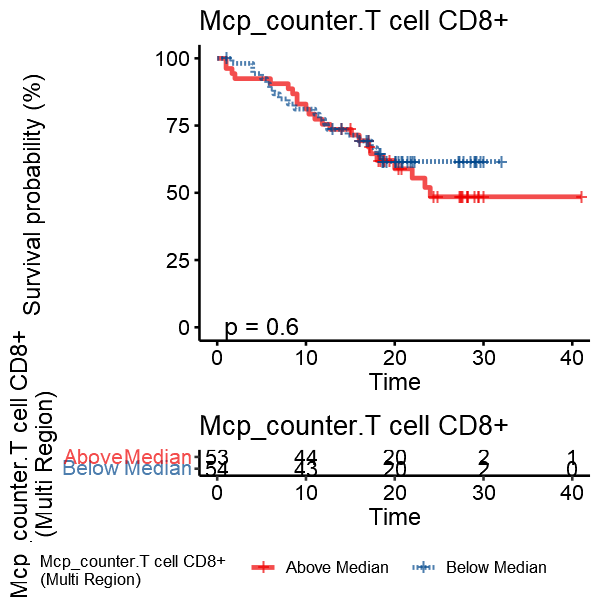

In [147]:

library(survival)
library(survminer)

options(repr.plot.width = 8, repr.plot.height = 8)

celltypes<-c("Mcp_counter.T cell CD8+")
T_survival_cibersort<-survival_data

for (celltype in celltypes){
#gene="IGHG_redundant"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]>median(T_survival_cibersort[,celltype])]<-"high"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]<=median(T_survival_cibersort[,celltype])]<-"low"

fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=T_survival_cibersort)

options(repr.plot.width = 5, repr.plot.height = 5)
xx1<-ggsurvplot(fit, data = T_survival_cibersort,
           conf.int = FALSE,
           pval = TRUE,           
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           #palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           palette = c(mypal[2],mypal[1]),
           legend = "bottom",
           legend.labs = c("Above Median","Below Median"),
           legend.title = paste(celltype,"\n(Multi Region)",sep="")
           )+ggtitle(paste(celltype,"",sep=""))
#if(surv_pvalue(fit)$pval<=0.05){
    print(xx1)
#}
}

### 4.1.2 McP B cell

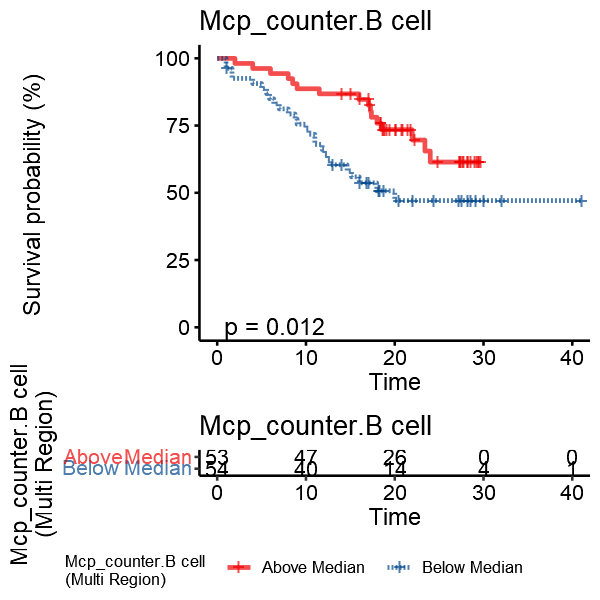

In [148]:
celltypes<-c("Mcp_counter.B cell")
T_survival_cibersort<-survival_data

for (celltype in celltypes){
#gene="IGHG_redundant"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]>median(T_survival_cibersort[,celltype])]<-"high"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]<=median(T_survival_cibersort[,celltype])]<-"low"

fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=T_survival_cibersort)

options(repr.plot.width = 5, repr.plot.height = 5)
xx2<-ggsurvplot(fit, data = T_survival_cibersort,
           conf.int = FALSE,
           pval = TRUE,           
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           #palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           palette = c(mypal[2],mypal[1]),
           legend = "bottom",
           legend.labs = c("Above Median","Below Median"),
           legend.title = paste(celltype,"\n(Multi Region)",sep="")
           )+ggtitle(paste(celltype,"",sep=""))
#if(surv_pvalue(fit)$pval<=0.05){
    print(xx2)
#}
}

### Mcp CD8+ T and B cell

In [11]:
T_survival_cibersort[1:3,]

T_survival_cibersort_selected<-T_survival_cibersort[,c('Survival_time','Survival_status','Mcp_counter.T cell CD8+','Mcp_counter.B cell')]
T_survival_cibersort_selected[1:3,]

write.csv(T_survival_cibersort_selected,"Fig3ABC.csv",row.names=FALSE,quote=FALSE)

ID        Patient_ID Survival_time Survival_status Age_flag    Gender
1 ESCC001T1 ESCC001    14            0               older(>=60) Male  
2 ESCC002T1 ESCC002    13            0               younger     Male  
3 ESCC004T4 ESCC004    32            0               older(>=60) Male  
  Location TNM_flag Smoking  Drinking grade_flag s_richness s_shannon
1 Middle   ⅡII      never    never    G2         264.0      4.963061 
2 Middle   ⅡII      moderate never    G2          50.5      3.192715 
3 Lower    ⅡII      heavy    never    G3         111.0      2.319196 
  sequence.richness.IGHM sequence.richness.IGHD sequence.richness.IGHA1
1 3.0                    2                      11.0                   
2 1.0                    0                       5.5                   
3 0.5                    0                       3.5                   
  sequence.richness.IGHA2 sequence.richness.IGHG1 sequence.richness.IGHG2
1 3.0                     129.0                   98.0                   
2 2.5                      19.0                   23.5                   
3 1.0                      57.5                   46.5                   
  sequence.richness.IGHG3 sequence.richness.IGHG4 sequence.richness.IGHE
1 8                       3                       0                     
2 1                       0                       0                     
3 2                       0                       0                     
  Mcp_counter.T cell CD8+ Mcp_counter.B cell celltype_flag
1 0.08                    224.39556          Low/Low      
2 0.00                     33.51389          Low/Low      
3 0.47                    104.66722          Low/Low

Survival_time Survival_status Mcp_counter.T cell CD8+ Mcp_counter.B cell
1 14            0               0.08                    224.39556         
2 13            0               0.00                     33.51389         
3 32            0               0.47                    104.66722

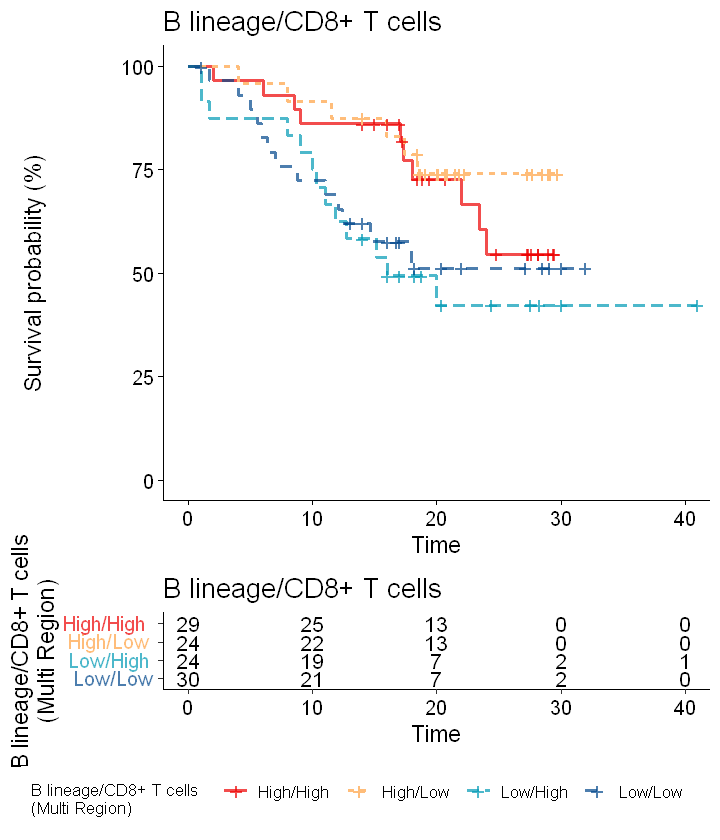

In [8]:

library(survival)
library(survminer)

options(repr.plot.width = 8, repr.plot.height = 8)

celltypes<-c("Mcp_counter.T cell CD8+","Mcp_counter.B cell")
T_survival_cibersort<-survival_data


#gene="IGHG_redundant"
T_data<-T_survival_cibersort$`Mcp_counter.T cell CD8+`
B_data<-T_survival_cibersort$`Mcp_counter.B cell`
T_survival_cibersort$celltype_flag=""
T_survival_cibersort$celltype_flag[B_data>median(B_data) & T_data>median(T_data)]<-"High/High"
T_survival_cibersort$celltype_flag[B_data>median(B_data) & T_data<=median(T_data)]<-"High/Low"
T_survival_cibersort$celltype_flag[B_data<=median(B_data) & T_data>median(T_data)]<-"Low/High"
T_survival_cibersort$celltype_flag[B_data<=median(B_data) & T_data<=median(T_data)]<-"Low/Low"

fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=T_survival_cibersort)
options(repr.plot.width = 6, repr.plot.height = 7)
xx<-ggsurvplot(fit, data = T_survival_cibersort,
           conf.int = FALSE,
           #pval = TRUE,           
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           #palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           palette = c(mypal[2],mypal[3],mypal[4],mypal[1]),
           legend = "bottom",
           legend.labs = c("High/High","High/Low","Low/High","Low/Low"),
           legend.title = paste("B lineage/CD8+ T cells","\n(Multi Region)",sep="")
           )+ggtitle(paste("B lineage/CD8+ T cells","",sep=""))
#if(surv_pvalue(fit)$pval<=0.05){
    print(xx)
#}


In [151]:
pdf("Bcell_CD8_survival.pdf",6,7)
xx1
xx2
xx
dev.off()

png 
  2

In [150]:
pdf("Bcell_CD8_survival.median.pdf",12,4)
xx1+xx2+xx+plot_layout(nrow=1)
dev.off()

Warning message in `+.ggsurv`(xx1, xx2):
"不可兼容的方法("+.gg", "+.ggsurv")和"+""


ERROR: Error in p + e2: 二进列运算符中有非数值参数


In [145]:
# HH HL
log_rank_p_mat<-tibble()
for(x in c("High/High","High/Low","Low/High","Low/Low")){
    for (y in c("High/High","High/Low","Low/High","Low/Low")){
        if(x==y){next}
        selected<-T_survival_cibersort$celltype_flag==x | T_survival_cibersort$celltype_flag==y
        data_selected<-T_survival_cibersort[selected,]
        fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=data_selected)
        p=round(surv_pvalue(fit)$pval,5)
        
        row=c(x,y,p)
        log_rank_p_mat<-rbind(log_rank_p_mat,row)
    }
}

colnames(log_rank_p_mat)<-c("V1","V2","pval")
log_rank_p_mat

V1        V2        pval   
1  High/High High/Low  0.49671
2  High/High Low/High  0.08053
3  High/High Low/Low   0.15719
4  High/Low  High/High 0.49671
5  High/Low  Low/High  0.02311
6  High/Low  Low/Low   0.05582
7  Low/High  High/High 0.08053
8  Low/High  High/Low  0.02311
9  Low/High  Low/Low   0.68679
10 Low/Low   High/High 0.15719
11 Low/Low   High/Low  0.05582
12 Low/Low   Low/High  0.68679

#### log_rang_p matrix

In [13]:
# HH HL
log_rank_p_mat<-tibble()
for(x in c("High/High","High/Low","Low/High","Low/Low")){
    for (y in c("High/High","High/Low","Low/High","Low/Low")){
        if(x==y){next}
        selected<-T_survival_cibersort$celltype_flag==x | T_survival_cibersort$celltype_flag==y
        data_selected<-T_survival_cibersort[selected,]
        fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=data_selected)
        p=round(surv_pvalue(fit)$pval,5)
        
        row=c(x,y,p)
        log_rank_p_mat<-rbind(log_rank_p_mat,row)
    }
}

colnames(log_rank_p_mat)<-c("V1","V2","pval")
log_rank_p_mat

V1        V2        pval   
1  High/High High/Low  0.39892
2  High/High Low/High  0.00072
3  High/High Low/Low   0.00594
4  High/Low  High/High 0.39892
5  High/Low  Low/High  1e-04  
6  High/Low  Low/Low   0.00107
7  Low/High  High/High 0.00072
8  Low/High  High/Low  1e-04  
9  Low/High  Low/Low   0.33174
10 Low/Low   High/High 0.00594
11 Low/Low   High/Low  0.00107
12 Low/Low   Low/High  0.33174

In [130]:
#expr
data_multi<-fread("MR_expr_cibersort_input.new.txt")%>% as.data.frame()
data_multi_expr<-column_to_rownames(data_multi,var="GENE")

data_multi_mat<-t(data_multi_expr)
colnames(data_multi_mat)<-data_multi[,1]
MR_expr<-as.data.frame(data_multi_mat)
#MR_expr<-rownames_to_column(MR_expr,var="ID")

dim(MR_expr)
MR_expr[1:5,1:5]

[1]   654 60583

TSPAN6 TNMD DPM1   SCYL3 C1orf112
ESCC001N  38.47  0.18  38.96 3.80  3.79    
ESCC001T1  7.41  0.00  73.86 2.85  8.43    
ESCC001T2  6.30  0.00  91.77 2.21  7.76    
ESCC001T3  9.95  0.00 110.20 2.27  7.66    
ESCC001T4  5.61  0.00 117.69 2.19  8.86

In [131]:
module_score<-AddModuleScore_bulk(t(MR_expr),features=mapk_list, name='module_score')
module_score<-data.frame(t(module_score))
module_score<-rownames_to_column(module_score,var="ID")

data_merged_module_score<-merge(survival_IGH_deversity_gene_expr_deconv,module_score,by="ID")
data_merged_module_score<-data.frame(data_merged_module_score,check.names = FALSE)
data_merged_module_score$Survival_status<-as.numeric(data_merged_module_score$Survival_status)


ERROR: Error in AddModuleScore_bulk(t(MR_expr), features = mapk_list, name = "module_score"): 没有"AddModuleScore_bulk"这个函数


## Fig 3E

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


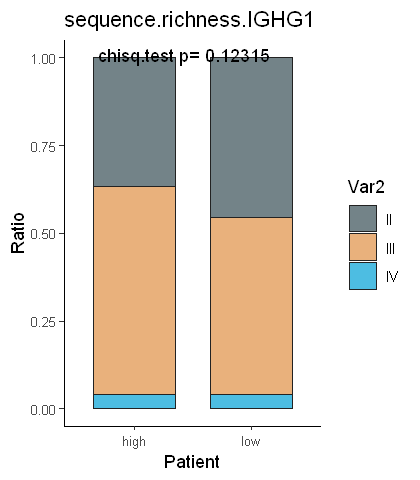

In [12]:
options(repr.plot.width = 3.5, repr.plot.height = 4)

T_data<-survival_IGH_deversity_gene_expr_deconv[grep("T",survival_IGH_deversity_gene_expr_deconv$type),]

data<-T_data[,c("ID","Patient_ID","TNM","Tumor_grade","COL6A5","ACTN1",colnames(T_data)[grep("sequence.richness.",colnames(T_data))],"IGHG2")]

data$TNM_flag[data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"II"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
data$TNM_flag[data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa")]<-"III"#,"\u2162" # Ⅲ
data$TNM_flag[data$TNM %in% c("IVa")]<-"IV"#"\u2163" # Ⅳ

# data$TNM_flag[data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"I & II"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
# data$TNM_flag[data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa","IVa")]<-"III & IV"#,"\u2162" # Ⅲ

data$grade_flag[data$Tumor_grade %in% c("G1")]<-"G1"#"Ⅰ&Ⅱ"#\u2160&
data$grade_flag[data$Tumor_grade %in% c("G1-2","G2")]<-"G2" # Ⅲ
data$grade_flag[data$Tumor_grade %in% c("G2-3","G2-G3","G2/3","G3","Upper G2, Lower G3")]<-"G3"

gene="sequence.richness.IGHG1"

data$gene_flag[data[,gene]>median(data[,gene])]<-"high"
data$gene_flag[data[,gene]<=median(data[,gene])]<-"low"

#chisq.test
chi<-table(data$gene_flag,data$TNM_flag) %>% chisq.test()
p=round(chi$`p.value`,digit=5)

Cellratio<-prop.table(table(data$gene_flag,data$TNM_flag),margin=1)

Cellratio<- as.data.frame(Cellratio)
p_chi<-ggplot(Cellratio)+
    geom_bar(aes(x=Var1,y=Freq,fill=Var2),stat="identity",width=0.7,size=0.5,colour="#222222")+
    annotate("text",x=-Inf,y=Inf,vjust=1.5,hjust=-0.2,label=paste("chisq.test p=",p))+
    theme_classic()+
    labs(x='Patient',y='Ratio')+
    scale_fill_manual(values=mypal2)+
    #theme(panel.border = element_rect(fill=NA,color="black",size=0.5,linetype="solid"))+
    theme(axis.text =element_text(size=8))+
    ggtitle(gene)
p_chi


In [14]:
Cellratio
write.csv(Cellratio,"Fig3E.csv",quote=FALSE,row.names=FALSE)

Var1 Var2 Freq      
1 high II   0.36585366
2 low  II   0.45528455
3 high III  0.59349593
4 low  III  0.50406504
5 high IV   0.04065041
6 low  IV   0.04065041

In [ ]:

#chisq.test
chi<-table(data$gene_flag,data$grade_flag) %>% chisq.test()
p=round(chi$`p.value`,digit=5)

Cellratio<-prop.table(table(data$gene_flag,data$grade_flag),margin=1)
Cellratio<- as.data.frame(Cellratio)
ggplot(Cellratio)+
    geom_bar(aes(x=Var1,y=Freq,fill=Var2),stat="identity",width=0.7,size=0.5,colour="#222222")+
    annotate("text",x=-Inf,y=Inf,vjust=1.5,hjust=-0.2,label=paste("chisq.test p=",p))+
    theme_classic()+
    labs(x='Patient',y='Ratio')+
    scale_fill_manual(values=mypal3)+
    theme(panel.border = element_rect(fill=NA,color="black",size=0.5,linetype="solid"))+
    theme(axis.text =element_text(size=16))+
    ggtitle(gene)


In [51]:
pdf("Fig3.TNM_IGHG1.pdf",3,3)
p_chi
dev.off()

png 
  2

## 肿瘤和癌旁BCR多样性指标与细胞亚型之间相关性分析

## Fig3D

In [ ]:
gsub(colnames(T_data),pattern = "s_", replacement = "sequence.")

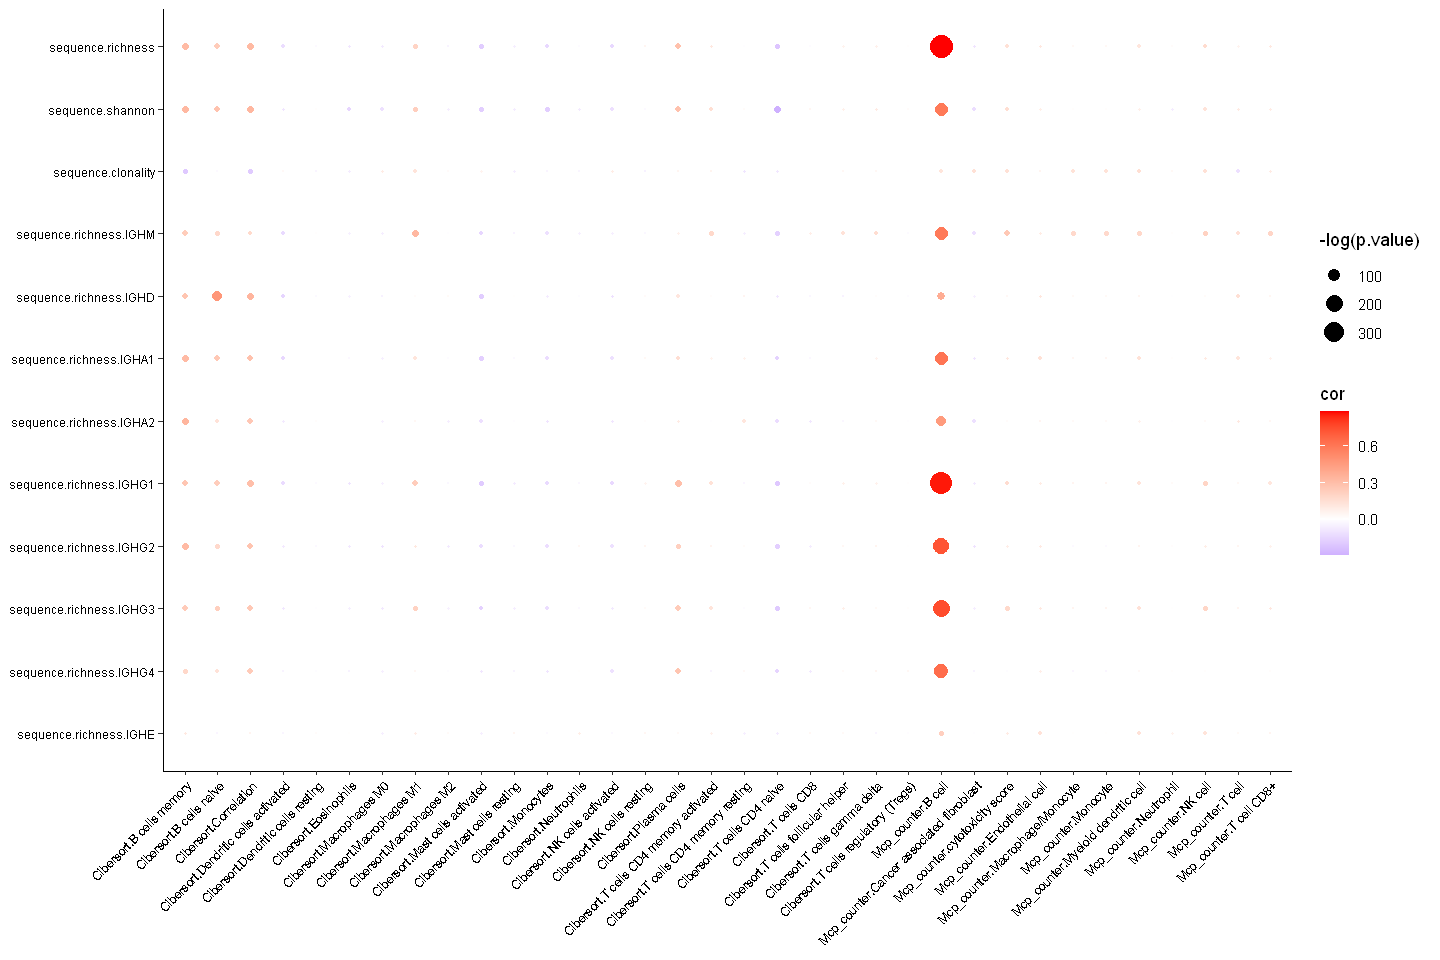

In [21]:
T_data<-survival_IGH_deversity_gene_expr_deconv[grep("T",survival_IGH_deversity_gene_expr_deconv$type),]
colnames(T_data)<-gsub(colnames(T_data),pattern = "s_", replacement = "sequence.")


cor_list<-data.frame(matrix(nrow=0,ncol=3))

celltypes<-colnames(T_data)[match("Cibersort.B cells naive",colnames(T_data)):match("Mcp_counter.Cancer associated fibroblast",colnames(T_data))]

features<-c(grep("sequence.",colnames(T_data)))
features<-colnames(T_data)[features]
features<-features[-grep("count_",features)]
features<-features[-grep("proportion",features)]

cor_list<-data.frame(matrix(nrow=0,ncol=3))
for(feature in features){
    for (celltype in celltypes){
        celltype_data<-T_data[,match(celltype,colnames(T_data))]
    
        test<-cor.test(T_data[,feature],celltype_data)
        rows<-data.frame("feature"=feature,"celltype"=celltype,"cor"=test$estimate,"p.value"=test$p.value)
        cor_list<-rbind(cor_list,rows)
    }
}
cor_list$feature<-factor(cor_list$feature,levels<-rev(features))
cor_list<-cor_list[-grep("P-value",cor_list$celltype),]
cor_list<-cor_list[-grep("RMSE",cor_list$celltype),]

options(repr.plot.width = 12, repr.plot.height =8)

cor_list<-na.omit(cor_list)

cor_of_IGH_with_celltype<-ggplot(cor_list,aes(y=feature,x= celltype,color=cor)) + 
  geom_point(aes(size=-log(p.value))) +
  scale_size(rang = c(0,6)) +
  scale_x_discrete(position = "bottom" ,expand=c(0.02,0))+
  labs(x=NULL,y=NULL)+  
  theme_classic()+
  theme(axis.text.x=element_text(angle=45,hjust = 1,vjust=1),
        panel.border = element_blank(),
        axis.text =element_text(size = 7, color = "black")
        )+ 
      scale_color_gradient2(low = "blue", high = "red",mid = "white",midpoint=0)

cor_of_IGH_with_celltype


In [18]:
write.csv(cor_list,"Fig3D.csv",quote=FALSE,row.names=FALSE)

In [46]:

pdf("Fig3.cor_of_IGH_with_celltype.pdf",7,4)
cor_of_IGH_with_celltype
dev.off()

png 
  2

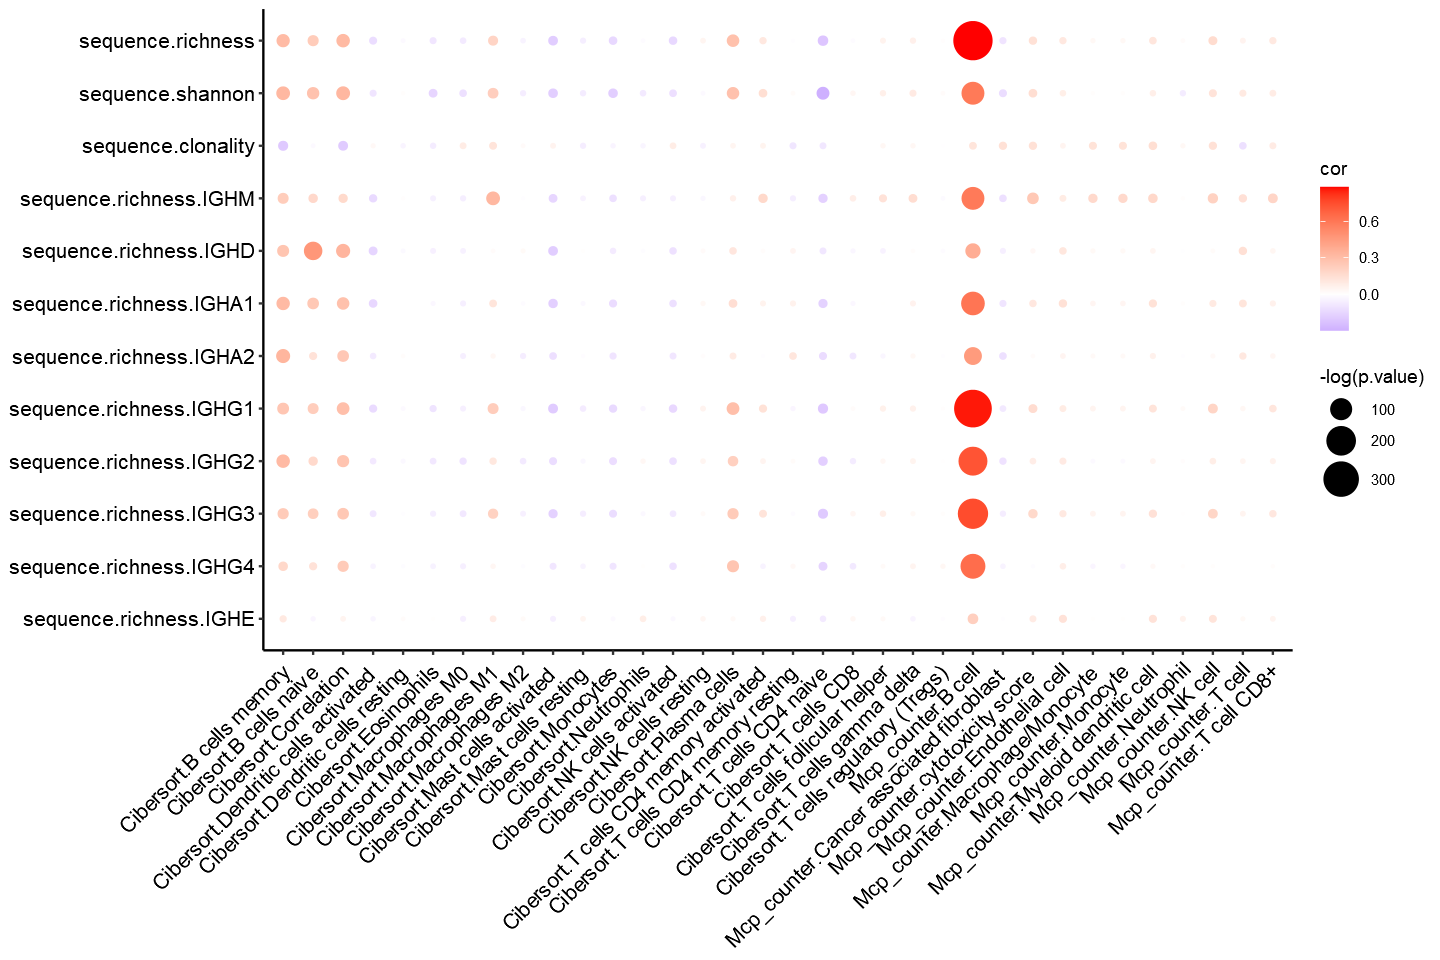

In [41]:
cor_of_IGH_with_celltype


## 基因与生存的关系测试

# Fig3G

In [50]:
survival_data<-T_data

survival_data$TNM_flag[survival_data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"ⅡII"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
survival_data$TNM_flag[survival_data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa")]<-"ⅢIII"#,"\u2162" # Ⅲ
survival_data$TNM_flag[survival_data$TNM %in% c("IVa")]<-"ⅣIV"#"\u2163" # Ⅳ

survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1")]<-"G1"#"Ⅰ&Ⅱ"#\u2160&
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1-2","G2")]<-"G2" # Ⅲ
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G2-3","G2-G3","G2/3","G3","Upper G2, Lower G3")]<-"G3"

survival_data$Location[survival_data$Location=="Upper&Lower"]="Upper"

survival_data$Age_flag[survival_data$Age>=60]<-"older(>=60)"
survival_data$Age_flag[survival_data$Age<60]<-"younger"

diversity_features<-c('s_richness','s_shannon',
    'sequence.richness.IGHM',
    'sequence.richness.IGHD',
    'sequence.richness.IGHA1','sequence.richness.IGHA2',
    'sequence.richness.IGHG1','sequence.richness.IGHG2','sequence.richness.IGHG3','sequence.richness.IGHG4',
    'sequence.richness.IGHE'
    )

selected_cols<-colnames(survival_data) %in% c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag",diversity_features)
survival_data<-survival_data[,selected_cols]



In [51]:

patients<-unique(survival_data$Patient_ID)
survival_data_m<-tibble()
    for(p in patients){
        p_data<-survival_data[survival_data$Patient_ID==p,]
        p_data_info<-p_data[1,c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag")]
        p_data_info<-as.vector(t(p_data_info))

        p_data_feature<-p_data[,diversity_features]
        p_data_feature_new<-apply(p_data_feature,2,function(x){median(x)})
        p_data_m<-c(p_data_info,p_data_feature_new)
        survival_data_m<-rbind(survival_data_m,p_data_m)
    }

colnames(survival_data_m)<-c(c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag"),diversity_features)
survival_data_m[,c("Survival_time","Survival_status",diversity_features)]<-apply(survival_data_m[,c("Survival_time","Survival_status",diversity_features)],2,function(x){as.numeric(x)})

survival_data<-as.data.frame(survival_data_m)

unique(survival_data$TNM)
dim(survival_data)

survival_data$Age_flag<-factor(survival_data$Age_flag,levels=c("younger","older(>=60)"))
survival_data$Smoking<-factor(survival_data$Smoking,levels=c("never","light","moderate","heavy"))
survival_data$Drinking<-factor(survival_data$Drinking,levels=c("never","light","moderate","heavy"))
#survival_data$TNM_flag<-factor(survival_data$TNM_flag,levels=c("II","III","IV"))


[1] "ⅡII"  "ⅢIII" "ⅣIV"

[1] 107  22

In [52]:

patients<-unique(survival_data$Patient_ID)
survival_data_m<-tibble()
    for(p in patients){
        p_data<-survival_data[survival_data$Patient_ID==p,]
        p_data_info<-p_data[1,c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag")]
        p_data_info<-as.vector(t(p_data_info))

        p_data_feature<-p_data[,diversity_features]
        p_data_feature_new<-apply(p_data_feature,2,function(x){median(x)})
        p_data_m<-c(p_data_info,p_data_feature_new)
        survival_data_m<-rbind(survival_data_m,p_data_m)
    }

colnames(survival_data_m)<-c(c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag"),diversity_features)
survival_data_m[,c("Survival_time","Survival_status",diversity_features)]<-apply(survival_data_m[,c("Survival_time","Survival_status",diversity_features)],2,function(x){as.numeric(x)})

survival_data<-as.data.frame(survival_data_m)

unique(survival_data$TNM)
dim(survival_data)

survival_data$Age_flag<-factor(survival_data$Age_flag,levels=c("younger","older(>=60)"))
survival_data$Smoking<-factor(survival_data$Smoking,levels=c("never","light","moderate","heavy"))
survival_data$Drinking<-factor(survival_data$Drinking,levels=c("never","light","moderate","heavy"))
#survival_data$TNM_flag<-factor(survival_data$TNM_flag,levels=c("II","III","IV"))


[1] "ⅡII"  "ⅢIII" "ⅣIV"

[1] 107  22

In [57]:
write.csv(data[,1:13],"Fig3G.csv",quote=FALSE,row.names=FALSE)

[1] "s_richness_flag"
Call:
coxph(formula = Surv(Survival_time, Survival_status) ~ Age_flag + 
    Gender + Location + TNM_flag + Smoking + Drinking + s_richness, 
    data = data)

  n= 107, number of events= 42 

                        coef exp(coef) se(coef)      z Pr(>|z|)    
Age_flagolder(>=60)  0.68828   1.99029  0.36754  1.873  0.06112 .  
GenderMale          -0.18792   0.82868  0.42569 -0.441  0.65889    
LocationMiddle      -0.40361   0.66790  0.38658 -1.044  0.29646    
LocationUpper       -1.02956   0.35716  1.09516 -0.940  0.34716    
TNM_flagⅢIII         1.03691   2.82050  0.39551  2.622  0.00875 ** 
TNM_flagⅣIV          0.09346   1.09797  1.08663  0.086  0.93146    
Smokinglight        -0.53865   0.58354  1.11574 -0.483  0.62926    
Smokingmoderate      0.76365   2.14608  0.53535  1.426  0.15374    
Smokingheavy        -0.29663   0.74332  0.51513 -0.576  0.56473    
Drinkinglight        0.16786   1.18277  0.60638  0.277  0.78191    
Drinkingmoderate    -0.60081   0.5483

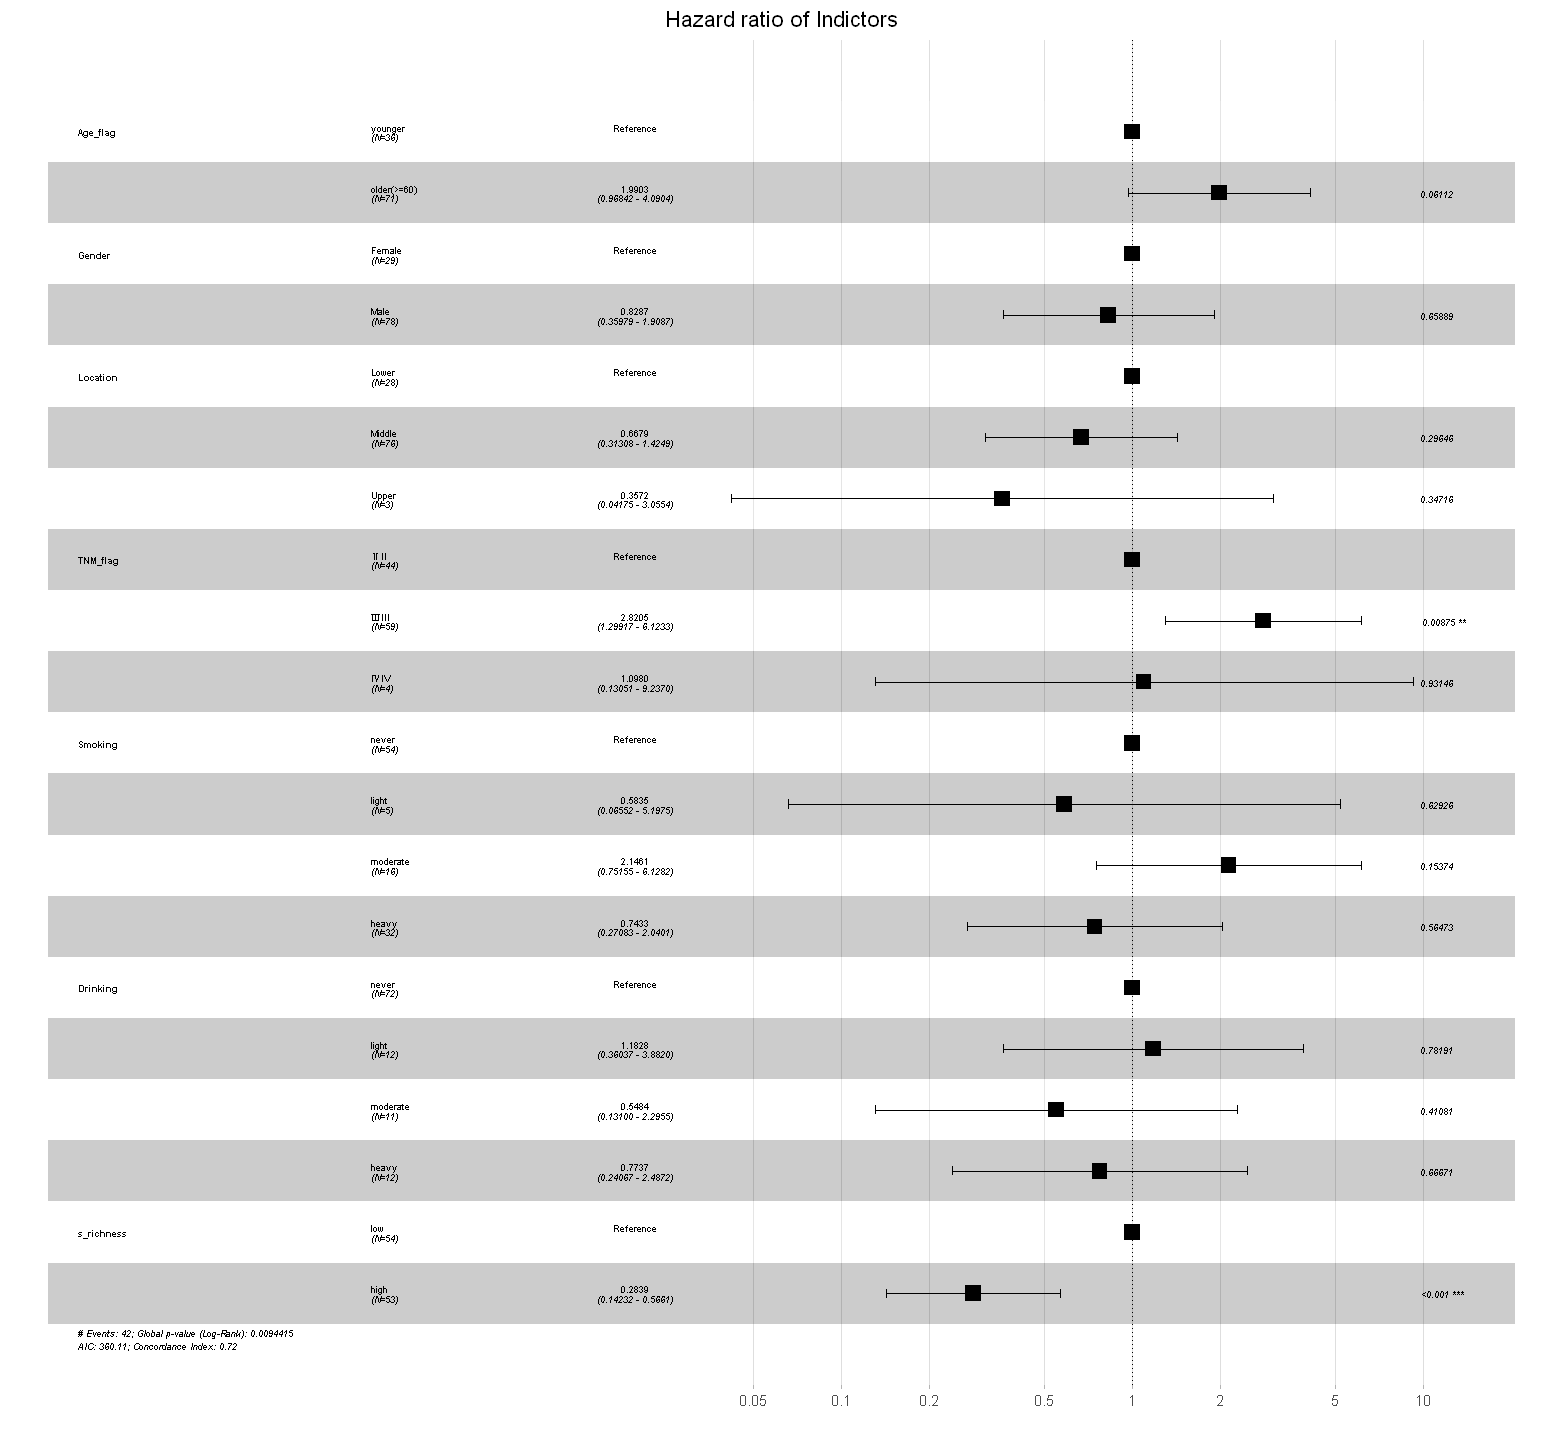

In [53]:
library("survival")
library("survminer")
data<-survival_data

diversity_features<-c(
        's_richness'
    )

for (flag in diversity_features){
    high_rows<-data[,flag]>median(data[,flag])
    low_rows<-data[,flag]<=median(data[,flag])
    data[high_rows,flag]<-"high"
    data[low_rows,flag]<-"low"
    data[,flag]<-factor(data[,flag],levels=c("low","high"))
}

options(repr.plot.width = 13, repr.plot.height = 12)

        res.cox <- coxph(
                Surv(Survival_time,Survival_status) ~Age_flag + Gender +Location+ TNM_flag + Smoking + Drinking +s_richness,
                data =  data)

        print(paste(flag,"_flag",sep=""))
        print(summary(res.cox))
        #pdf("IGHG_redundant.forestplot.pdf",9,6)
        gf_richnees<-ggforest(res.cox,  #coxph得到的Cox回归结果
                data = data,  #数据集
                main = paste('Hazard ratio of Indictors'),  #标题
        # cpositions = c(0.05, 0.15, 0.35),  #前三列数值的距离
                fontsize = 0.5, #字体大小
                refLabel = 'Reference', #相对变量的标签
                noDigits = 4 #HR、95%CI的小数位
                )
        print(gf_richnees)

# Fig3F

In [58]:
survival_data<-T_data

survival_data$TNM_flag[survival_data$TNM %in% c("Ⅱb","Ⅱa","IIa","IIb","IB")]<-"ⅡII"#"\u2161"#"Ⅰ&Ⅱ"#\u2160&
survival_data$TNM_flag[survival_data$TNM %in% c("Ⅲa","Ⅲc","Ⅲb","IIIb","IIIa")]<-"ⅢIII"#,"\u2162" # Ⅲ
survival_data$TNM_flag[survival_data$TNM %in% c("IVa")]<-"ⅣIV"#"\u2163" # Ⅳ

survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1")]<-"G1"#"Ⅰ&Ⅱ"#\u2160&
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G1-2","G2")]<-"G2" # Ⅲ
survival_data$grade_flag[survival_data$Tumor_grade %in% c("G2-3","G2-G3","G2/3","G3","Upper G2, Lower G3")]<-"G3"

survival_data$Location[survival_data$Location=="Upper&Lower"]="Upper"

survival_data$Age_flag[survival_data$Age>=60]<-"older(>=60)"
survival_data$Age_flag[survival_data$Age<60]<-"younger"

diversity_features<-c('s_richness','s_shannon',
    'sequence.richness.IGHM',
    'sequence.richness.IGHD',
    'sequence.richness.IGHA1','sequence.richness.IGHA2',
    'sequence.richness.IGHG1','sequence.richness.IGHG2','sequence.richness.IGHG3','sequence.richness.IGHG4',
    'sequence.richness.IGHE'
    )

selected_cols<-colnames(survival_data) %in% c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag",diversity_features)
survival_data<-survival_data[,selected_cols]


patients<-unique(survival_data$Patient_ID)
survival_data_m<-tibble()
    for(p in patients){
        p_data<-survival_data[survival_data$Patient_ID==p,]
        p_data_info<-p_data[1,c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag")]
        p_data_info<-as.vector(t(p_data_info))

        p_data_feature<-p_data[,diversity_features]
        p_data_feature_new<-apply(p_data_feature,2,function(x){median(x)})
        p_data_m<-c(p_data_info,p_data_feature_new)
        survival_data_m<-rbind(survival_data_m,p_data_m)
    }

colnames(survival_data_m)<-c(c("ID","Patient_ID","Survival_time","Survival_status","Age_flag","Gender","Location","TNM_flag","Smoking","Drinking","grade_flag"),diversity_features)
survival_data_m[,c("Survival_time","Survival_status",diversity_features)]<-apply(survival_data_m[,c("Survival_time","Survival_status",diversity_features)],2,function(x){as.numeric(x)})

survival_data<-as.data.frame(survival_data_m)

unique(survival_data$TNM)
dim(survival_data)

survival_data$Age_flag<-factor(survival_data$Age_flag,levels=c("younger","older(>=60)"))
survival_data$Smoking<-factor(survival_data$Smoking,levels=c("never","light","moderate","heavy"))
survival_data$Drinking<-factor(survival_data$Drinking,levels=c("never","light","moderate","heavy"))
#survival_data$TNM_flag<-factor(survival_data$TNM_flag,levels=c("II","III","IV"))


[1] "ⅡII"  "ⅢIII" "ⅣIV"

[1] 107  22

In [60]:
write.csv(T_survival_cibersort,"Fig3F.csv",quote=FALSE,row.names=FALSE)

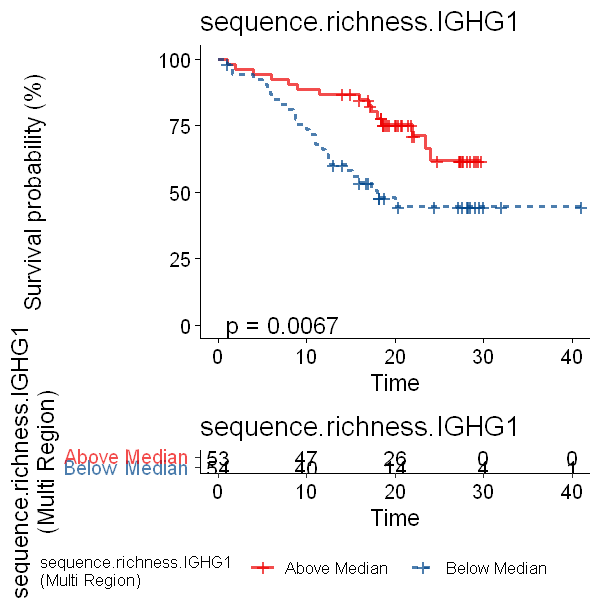

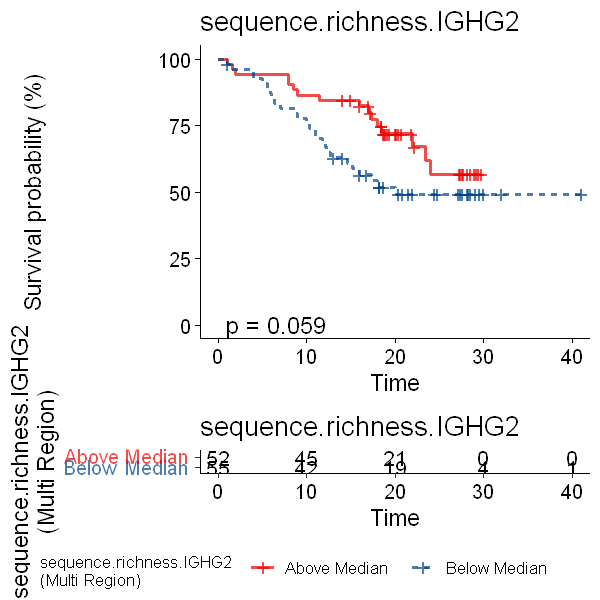

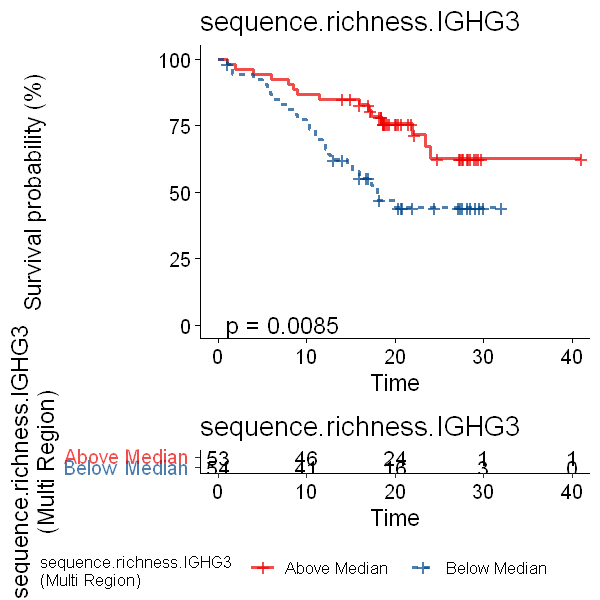

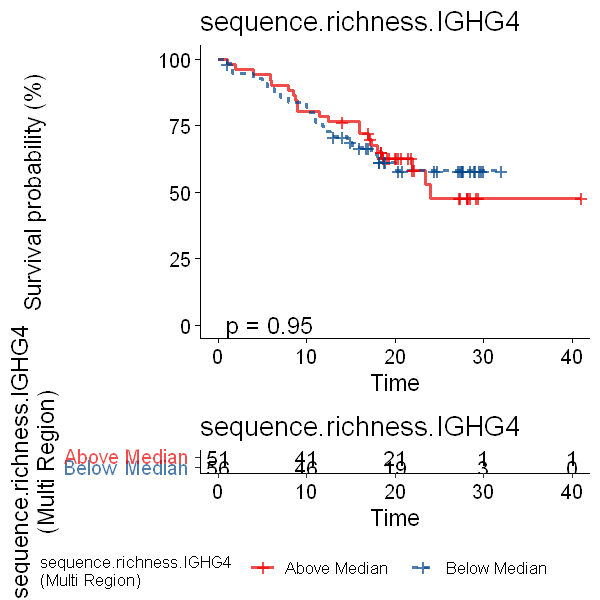

In [59]:

library(survival)
library(survminer)

options(repr.plot.width = 8, repr.plot.height = 8)

celltypes<-c('sequence.richness.IGHG1','sequence.richness.IGHG2','sequence.richness.IGHG3','sequence.richness.IGHG4')
T_survival_cibersort<-survival_data

for (celltype in celltypes){
#gene="IGHG_redundant"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]>median(T_survival_cibersort[,celltype])]<-"high"
T_survival_cibersort$celltype_flag[T_survival_cibersort[,celltype]<=median(T_survival_cibersort[,celltype])]<-"low"

fit<-survfit(Surv(Survival_time,Survival_status) ~celltype_flag, data=T_survival_cibersort)

options(repr.plot.width = 5, repr.plot.height = 5)
xx<-ggsurvplot(fit, data = T_survival_cibersort,
           conf.int = FALSE,
           pval = TRUE,           
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           #palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           palette = c(mypal[2],mypal[1]),
           legend = "bottom",
           legend.labs = c("Above Median","Below Median"),
           legend.title = paste(celltype,"\n(Multi Region)",sep="")
           )+ggtitle(paste(celltype,"",sep=""))
#if(surv_pvalue(fit)$pval<=0.05){
    print(xx)
#}
}

## MR cibersort cor with Mcp_counter

In [ ]:
# get Tumor sample ID
MR_Cirbersot_out<-fread("D:/Postdoc/Projects/ESCC_TCR/Deconvolution/MR_Cirbersot_out.new.txt") %>% as.data.frame()

res_mcp_counter_MR<-fread("D:/Postdoc/Projects/ESCC_TCR/TRUST/Trust4_vs_clinical_info/MR_deconvolution_mcp_counter.new.csv") %>% as.data.frame()
setwd("D:/Postdoc/Projects/ESCC_TCR/TRUST/Trust4_vs_clinical_info/")
MR_survival_gene_data<-fread("D:/Postdoc/Projects/ESCC_TCR/TRUST/Trust4_vs_clinical_info/MR_survival_gene_data.test.csv") %>% as.data.frame()
MR_T_sample<-MR_survival_gene_data$ID[grep("T",MR_survival_gene_data$type)]
# use only the Tumor sample
MR_Cirbersot_out<-MR_Cirbersot_out[MR_Cirbersot_out$ID %in% MR_T_sample,]

res_mcp_counter_MR<-res_mcp_counter_MR[,c(1,which(colnames(res_mcp_counter_MR) %in% MR_T_sample))]# use only the Tumor sample

cor.cibersort_mcp_counter<-data.frame(matrix(ncol=4,nrow=0))
for(B1 in colnames(MR_Cirbersot_out)[-c(1,24:26)]){
    for (B2 in res_mcp_counter_MR$cell_type){
    cor_result<-cor.test(MR_Cirbersot_out[,B1],as.numeric(res_mcp_counter_MR[res_mcp_counter_MR$`cell_type`==B2,][-1]),method="spearman",exact=FALSE)

    rows<-data.frame("Cibersort"=B1,"Mcp_counter"=B2,"rho"=cor_result$estimate,"p"=cor_result$p.value)
    cor.cibersort_mcp_counter<-rbind(cor.cibersort_mcp_counter,rows)
    }
}

options(repr.plot.width = 10, repr.plot.height = 10)

cor_list<-na.omit(cor.cibersort_mcp_counter)

ggplot(cor_list,aes(x=Mcp_counter,y= Cibersort,color=rho)) + 
  geom_point(aes(size=-log(p))) +
  scale_size(rang = c(0,10)) +
  scale_x_discrete(position = "bottom" ,expand=c(0.2,0))+
  labs(x=NULL,y=NULL)+  
  theme_test()+
  theme(axis.text.x=element_text(angle=90,hjust = 1,vjust=0.5),
        panel.border = element_blank(),
        axis.text =element_text(size = 12, color = "black"),
        axis.ticks = element_blank()
        )+ 
      scale_color_gradient2(low = "blue", high = "red",mid = "white",midpoint=0)

      #pheatmap cluster
data<-dcast(cor_list[,1:3],Cibersort~Mcp_counter,value.var="rho")
row.names(data)<-data$Cibersort
pheatmap(data[,-1])


In [ ]:
MR cibersort cor with cibersort

聚类分为三大块，1.血管相关，2.适应性免疫，3.炎症相关

In [ ]:
cor.cibersort_mcp_counter<-data.frame(matrix(ncol=4,nrow=0))
for(B1 in  colnames(MR_Cirbersot_out)[-c(1,24:26)]){
    for (B2 in  colnames(MR_Cirbersot_out)[-c(1,24:26)]){
    cor_result<-cor.test(MR_Cirbersot_out[,B1],MR_Cirbersot_out[,B2],method="spearman",exact=FALSE)

    rows<-data.frame("Cibersort"=B1,"Mcp_counter"=B2,"rho"=cor_result$estimate,"p"=cor_result$p.value)
    cor.cibersort_mcp_counter<-rbind(cor.cibersort_mcp_counter,rows)
    }
}

#cor.cibersort_mcp_counter[1:5,]

options(repr.plot.width = 10, repr.plot.height = 10)
cor_list<-na.omit(cor.cibersort_mcp_counter)
#cor_list<-na.omit(cor.cibersort_mcp_counter)

ggplot(cor_list,aes(x=Mcp_counter,y= Cibersort,color=rho)) + 
  geom_point(aes(size=-log(p))) +
  scale_size(rang = c(0,10)) +
  scale_x_discrete(position = "bottom" ,expand=c(0.2,0))+
  labs(x=NULL,y=NULL)+  
  theme_test()+
  theme(axis.text.x=element_text(angle=90,hjust = 1,vjust=0.5),
        panel.border = element_blank(),
        axis.text =element_text(size = 12, color = "black"),
        axis.ticks = element_blank()
        )+ 
      scale_color_gradient2(low = "blue", high = "red",mid = "white",midpoint=0)

set.seed(123)
#pheatmap cluster
data<-dcast(cor_list[,1:3],Cibersort~Mcp_counter,value.var="rho")
row.names(data)<-data$Cibersort
pheatmap(data[,-1])